In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import torchvision
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

In [33]:
#Load Images
def load_images(path):

    images = []
    filenames = os.listdir(path)
    
    for filename in tqdm(filenames): 
        if filename == '_DS_Store':
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(128,128))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    
    return np.array(images)

In [34]:
#載入資料
cats_train = load_images('/home/ttsai/DL_HW2/train/cat')
dogs_train = load_images('/home/ttsai/DL_HW2/train/dog')

cats_test = load_images('/home/ttsai/DL_HW2/test/cat')
dogs_test = load_images('/home/ttsai/DL_HW2/test/dog')


100%|██████████| 2500/2500 [00:01<00:00, 1267.74it/s]


In [35]:
#檢查陣列的形狀以及調整後的size
print(cats_train.shape)
print(dogs_train.shape)
print(cats_test.shape)
print(dogs_test.shape)

(10000, 128, 128, 3)
(10000, 128, 128, 3)
(2500, 128, 128, 3)
(2500, 128, 128, 3)


In [36]:
#將所有訓練資料和測試資料放入同一個陣列中
X_train = np.append(cats_train, dogs_train, axis=0)
X_test  = np.append(cats_test, dogs_test, axis=0)

print(X_train.shape)
print(X_test.shape)

(20000, 128, 128, 3)
(5000, 128, 128, 3)


In [37]:
#Creating Labels
y_train = np.array([0] * len(cats_train) + [1] * len(dogs_train))
y_test = np.array([0] * len(cats_test) + [1] * len(dogs_test))

print(y_train.shape)
print(y_test.shape)

(20000,)
(5000,)


In [38]:
#Displaying Several Images
def show_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i,j].set_title(labels[counter].item())
            axes[i,j].imshow(images[counter], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

In [39]:
# show_images(X_train, y_train, 0)

In [40]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

print(y_train[-1])


1


In [41]:
#Image Preprocessing and Augmentation
transforms_train = transforms.Compose([transforms.ToTensor(), # convert to tensor
                                       transforms.RandomRotation(degrees=20), 
                                       transforms.RandomHorizontalFlip(p=0.5), 
                                       transforms.RandomVerticalFlip(p=0.005), 
                                       transforms.RandomGrayscale(p=0.2), 
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [42]:
transforms_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [43]:
#Custom Dataset Class & Data Loader
class Cat_Dog_Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        
        return (image, label)

In [44]:
train_dataset = Cat_Dog_Dataset(images=X_train, labels=y_train, transform=transforms_train)
test_dataset  = Cat_Dog_Dataset(images=X_test, labels=y_test, transform=transforms_test)

In [45]:
#Data Loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True,pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True,pin_memory=True)

In [46]:
# #Visualizing Some Augmented Images
# iterator = iter(train_loader)
# image_batch, label_batch = next(iterator)

# print(image_batch.shape)
# image_batch_permuted = image_batch.permute(0, 2, 3, 1)

# print(image_batch_permuted.shape)

# show_images(image_batch_permuted, label_batch, 0)

In [47]:
#Create LeNet5 Model
class LeNet5(nn.Module):
    def __init__(self, num_classes=2):  # 修改這裡的參數名稱
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*12*12, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # 這裡修改為 num_classes
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [48]:
import torchvision.models as models
# model = LeNet5(num_classes=2)
model = models.alexnet(pretrained=True)
# num_classes = 2  # 两个类别
# model.classifier[6] = nn.Linear(4096, num_classes)
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# summary(model, (3, 128, 128))  # 此處的(3, 128, 128)是你期望的輸入圖像的形狀

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [49]:
#Model Training
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [50]:
#A Function to Predict Test Data
def predict_data(model, data):
    
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(data):
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)
            
            # Calculate accuracy
            test_preds_label = torch.argmax(test_preds, dim=1)
            num_correct += torch.sum(test_preds_label == y_test)
            num_samples += len(y_test)
        
    # model.train()
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

In [51]:
from torch.backends import cudnn
cudnn.benchmark = True # fast training

#The Training Loop
train_losses = []    # Training and testing loss was calculated based on the last batch of each epoch.
test_losses  = []
train_accs = []
test_accs  = []
num_epochs = 20

for epoch in range(num_epochs):
    
    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        

        optimizer.zero_grad()
        # Forward propagation
        train_preds = model(X_train)        
        train_loss = loss_function(train_preds, y_train)
        
        # # Calculate train accuracy
        
            
        # Backward propagation
        # optimizer.zero_grad()   
        train_loss.backward()        
        # Gradient descent
        optimizer.step()        

        # with torch.no_grad():
        train_preds_label = torch.argmax(train_preds, dim=1)       
        num_correct_train += torch.sum(train_preds_label == y_train)
        num_samples_train += len(y_train)
        
    scheduler.step()
    # print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate: {optimizer.param_groups[0]['lr']}")

    train_acc = num_correct_train/num_samples_train
    test_loss, test_acc = predict_data(model, test_loader)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
        
    print(f'Epoch: {epoch+1} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(test_acc.item(),2)} \t|' \
            f' Learning Rate: {optimizer.param_groups[0]["lr"]}' )

100%|██████████| 1250/1250 [00:19<00:00, 65.31it/s]


Epoch: 1 	| Train loss: 0.251 	| Test loss: 0.288 	| Train acc: 0.78 	| Test acc: 0.89 	| Learning Rate: 0.0009000000000000001


100%|██████████| 1250/1250 [00:18<00:00, 66.33it/s]


Epoch: 2 	| Train loss: 0.234 	| Test loss: 0.206 	| Train acc: 0.87 	| Test acc: 0.91 	| Learning Rate: 0.0008100000000000001


100%|██████████| 1250/1250 [00:18<00:00, 67.56it/s]


Epoch: 3 	| Train loss: 0.076 	| Test loss: 0.213 	| Train acc: 0.9 	| Test acc: 0.93 	| Learning Rate: 0.000729


100%|██████████| 1250/1250 [00:18<00:00, 68.41it/s]


Epoch: 4 	| Train loss: 0.167 	| Test loss: 0.177 	| Train acc: 0.92 	| Test acc: 0.93 	| Learning Rate: 0.0006561000000000001


100%|██████████| 1250/1250 [00:20<00:00, 62.17it/s]


Epoch: 5 	| Train loss: 0.175 	| Test loss: 0.112 	| Train acc: 0.92 	| Test acc: 0.93 	| Learning Rate: 0.00059049


100%|██████████| 1250/1250 [00:26<00:00, 47.94it/s]


Epoch: 6 	| Train loss: 0.427 	| Test loss: 0.023 	| Train acc: 0.93 	| Test acc: 0.94 	| Learning Rate: 0.000531441


100%|██████████| 1250/1250 [00:26<00:00, 48.06it/s]


Epoch: 7 	| Train loss: 0.191 	| Test loss: 0.228 	| Train acc: 0.94 	| Test acc: 0.93 	| Learning Rate: 0.0004782969


100%|██████████| 1250/1250 [00:25<00:00, 48.91it/s]


Epoch: 8 	| Train loss: 0.076 	| Test loss: 0.272 	| Train acc: 0.94 	| Test acc: 0.94 	| Learning Rate: 0.00043046721


100%|██████████| 1250/1250 [00:26<00:00, 46.55it/s]


Epoch: 9 	| Train loss: 0.022 	| Test loss: 0.806 	| Train acc: 0.95 	| Test acc: 0.94 	| Learning Rate: 0.000387420489


100%|██████████| 1250/1250 [00:25<00:00, 48.09it/s]


Epoch: 10 	| Train loss: 0.017 	| Test loss: 0.058 	| Train acc: 0.95 	| Test acc: 0.94 	| Learning Rate: 0.0003486784401


100%|██████████| 1250/1250 [00:24<00:00, 51.02it/s]


Epoch: 11 	| Train loss: 0.117 	| Test loss: 0.05 	| Train acc: 0.96 	| Test acc: 0.95 	| Learning Rate: 0.00031381059609000004


100%|██████████| 1250/1250 [00:25<00:00, 49.01it/s]


Epoch: 12 	| Train loss: 0.058 	| Test loss: 0.228 	| Train acc: 0.96 	| Test acc: 0.94 	| Learning Rate: 0.00028242953648100003


100%|██████████| 1250/1250 [00:25<00:00, 48.52it/s]


Epoch: 13 	| Train loss: 0.023 	| Test loss: 0.403 	| Train acc: 0.96 	| Test acc: 0.94 	| Learning Rate: 0.00025418658283290005


100%|██████████| 1250/1250 [00:26<00:00, 47.84it/s]


Epoch: 14 	| Train loss: 0.103 	| Test loss: 0.101 	| Train acc: 0.97 	| Test acc: 0.95 	| Learning Rate: 0.00022876792454961005


100%|██████████| 1250/1250 [00:26<00:00, 46.40it/s]


Epoch: 15 	| Train loss: 0.051 	| Test loss: 0.301 	| Train acc: 0.97 	| Test acc: 0.94 	| Learning Rate: 0.00020589113209464906


100%|██████████| 1250/1250 [00:27<00:00, 45.77it/s]


Epoch: 16 	| Train loss: 0.08 	| Test loss: 0.056 	| Train acc: 0.97 	| Test acc: 0.95 	| Learning Rate: 0.00018530201888518417


100%|██████████| 1250/1250 [00:19<00:00, 63.87it/s]


Epoch: 17 	| Train loss: 0.25 	| Test loss: 0.012 	| Train acc: 0.97 	| Test acc: 0.95 	| Learning Rate: 0.00016677181699666576


100%|██████████| 1250/1250 [00:23<00:00, 53.43it/s]


Epoch: 18 	| Train loss: 0.01 	| Test loss: 0.087 	| Train acc: 0.97 	| Test acc: 0.95 	| Learning Rate: 0.0001500946352969992


100%|██████████| 1250/1250 [00:22<00:00, 55.75it/s]


Epoch: 19 	| Train loss: 0.078 	| Test loss: 0.155 	| Train acc: 0.98 	| Test acc: 0.95 	| Learning Rate: 0.0001350851717672993


100%|██████████| 1250/1250 [00:25<00:00, 49.02it/s]


Epoch: 20 	| Train loss: 0.04 	| Test loss: 0.04 	| Train acc: 0.98 	| Test acc: 0.95 	| Learning Rate: 0.00012157665459056936


range(1, 21)


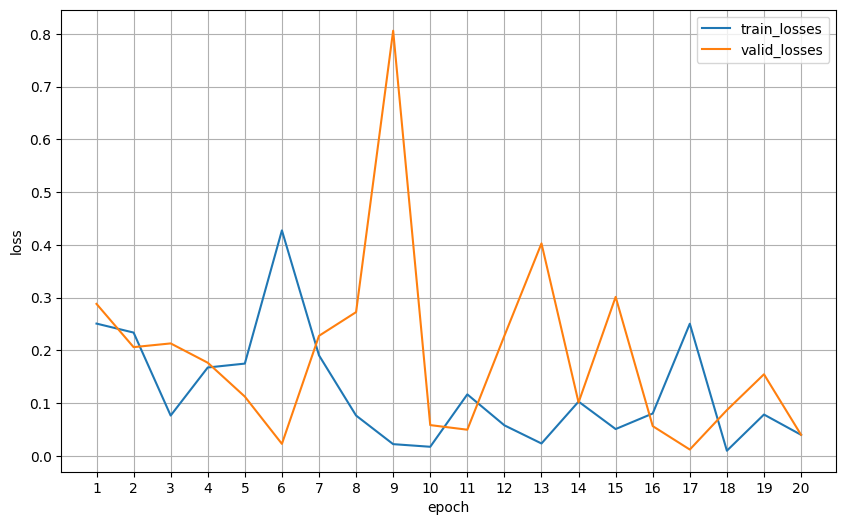

In [53]:
#Evaluation
plt.figure(figsize=(10,6))
plt.grid()
epochs = range(1, len(train_losses) + 1)
print(epochs)
plt.plot(epochs,train_losses)
plt.plot(epochs,test_losses)
plt.legend(['train_losses', 'valid_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(epochs)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs', 'test_accs'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [54]:
# model = torch.load('path_to_your_best_LeNet.pth')
model.eval()
accuracy = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100* correct / total
print('Accuracy: {:.2f}%'.format(accuracy))

Accuracy: 94.81%
